In [91]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [92]:
base_llm = "llama-3.3-70b-versatile"
heavier_llm = "openai/gpt-oss-120b"

In [93]:
from langchain_qdrant import QdrantVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

vectorstore = QdrantVectorStore.from_existing_collection(
    url="http://localhost:6333",
    collection_name="PONDICHERRY_UNIVERSITY_INFO",
    embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [ ]:
# Relevance grader
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq

# LLM
grader_model = ChatGroq(model=base_llm, temperature=1)
llm = grader_model.with_structured_output(method="json_mode")

prompt = PromptTemplate(
    template="""You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains any information or keywords related to the user question, 
    grade it as relevant. This is a very lenient test - the document does not need to fully answer the question to be considered relevant.
    
    Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.
    Also provide a brief explanation for your decision.
    
    Return your response as a JSON with two keys: 'score' (either 'yes' or 'no') and 'explanation'.
     
    Here is the retrieved document: 
    {document}
    
    Here is the user question: 
    {question}
    """,
    input_variables=["question", "document"]
)

retrieval_grader = prompt | llm

question = "What are some recent research fundings?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content

print(doc_txt)

print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

Section: Annual Capital Expenditure - Part 1

| Item                                                                                                 | 2023-24                                                                                 | 2022-23                                                                           | 2021-22                                                                                  |
|:-----------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------|
| Annual Capital Expenditure on Academic Activities and Resources (excluding expenditure on buildings) |                                                                                         |                    

In [95]:
# Generate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Output the answer with as much details as possible
    Question: {question} 
    Context: {context} 
    Answer: 
    """,
    input_variables=["question", "document"],
)

llm = ChatGroq(model=base_llm, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "recent fundings?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The recent fundings for Pondicherry University can be broken down into several categories based on the provided context. 

1. **Sponsored Projects Funding**: 
   - In the financial year 2023-24, the university received funding for 75 sponsored projects from 14 different funding agencies, with a total amount of 10 crore 24 lakhs 50 thousand and 95 rupees (approximately 102.46 million rupees).
   - In the financial year 2022-23, there were 43 sponsored projects funded by 12 agencies, totaling 6 crore 53 lakhs 17 thousand and 750 rupees (approximately 65.32 million rupees).
   - In the financial year 2021-22, the university had 22 sponsored projects funded by 15 agencies, with a total of 2 crore 71 lakhs 75 thousand and 141 rupees (approximately 27.18 million rupees).

2. **Consultancy Projects Revenue**:
   - For the financial year 2023-24, the university generated revenue from 40 consultancy projects with 33 client organizations, amounting to 1 crore 8 lakhs 66 thousand and 7 rupees (ap

In [96]:
# Basic Response

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks regarding Pondicherry University
    Look at the question and just simply greet the user with a warm message, introduce your capabilities of producing incredibly high quality low error data regarding the university data. Moveover you can do data analysis and get latest realtime data about the university.
    Don't reply with any information or data, even if it's present in your system.
    Question: {question} 
    """,
    input_variables=["question"],
)

llm = ChatGroq(model=heavier_llm, temperature=0)

# Chain
basic_rag_chain = prompt | llm | StrOutputParser()

# Run
question = "recent fundings?"
docs = retriever.invoke(question)

generation = basic_rag_chain.invoke({"question": question})
print(generation)

Hello! 👋 I'm here to help you with any information you need about Pondicherry University. I specialize in providing incredibly high‑quality, low‑error data about the university, and I can also perform data analysis and fetch the latest real‑time updates. Feel free to let me know what you’d like to explore!


In [97]:
### Hallucination Grader 
from langchain_core.output_parsers import JsonOutputParser
# LLM
llm = ChatGroq(model=heavier_llm, temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation.
    
    Here are the facts:
    {documents} 

    Here is the answer: 
    {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'no'}

In [98]:
### Answer Grader 

# LLM
llm = ChatGroq(model=heavier_llm, temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     
    Here is the answer:
    {generation} 

    Here is the question: {question}
    """,
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question,"generation": generation})

{'score': 'no'}

In [99]:
### Router

from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatGroq(model=heavier_llm)

prompt = PromptTemplate(
    template="""You are an expert routing model designed for GPT-OSS-120B.

            Your task is to decide how a user query should be handled.

            Routing Options:
            - "basic"        → For greetings or simple conversational messages that do NOT require any information retrieval or web search
            - "vectorstore"  → For questions that can be answered using internal or curated knowledge
            - "web_search"   → For questions that require real-time, current, or latest information

            Routing Rules:
            - If the user greets (e.g., "hi", "hello", "hey", "good morning") or writes a simple message that does not require retrieving information, choose "basic".
            - Use "vectorstore" for questions related to:
            - University-specific or internal information
            - Historical data, reports, statistics, funding, placements
            - Policies, rules, notices, circulars stored internally
            - Use "web_search" for questions that require:
            - Real-time or time-sensitive information
            - Latest updates, announcements, weather, or current events
            - Semantic similarity is sufficient; exact keyword matching is NOT required.

            Examples:

            Question: Hi
            Answer: {{"datasource": "basic"}}

            Question: What is the weather at Pondicherry University?
            Answer: {{"datasource": "web_search"}}

            Question: What are the fundings received in the last 3 years?
            Answer: {{"datasource": "vectorstore"}}

            Question: What are the placement data of the university?
            Answer: {{"datasource": "vectorstore"}}

            Question: What is the latest circular?
            Answer: {{"datasource": "web_search"}}

            Question to route:
            {question}
            """,
    input_variables=["question"],
)


question_router = prompt | llm | JsonOutputParser()

print(question_router.invoke({"question": "When will the Euro of Football take place?"}))
print(question_router.invoke({"question": "What is the weather?"}))
print(question_router.invoke({"question": "What is the average placements at the university?"}))
print(question_router.invoke({"question": "What are the research fundings in the last 3 years?"}))
print(question_router.invoke({"question": "What is the latest circular?"})) ### Index
print(question_router.invoke({"question": "Hi there"})) ### Index
print(question_router.invoke({"question": "How are you?"})) ### Index

{'datasource': 'web_search'}
{'datasource': 'web_search'}
{'datasource': 'vectorstore'}
{'datasource': 'vectorstore'}
{'datasource': 'web_search'}
{'datasource': 'basic'}
{'datasource': 'basic'}


In [100]:
### Search

from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(k=3)

In [ ]:
from langchain_core.documents import Document

def web_search(state):
    question = state["question"]
    # if state["documents"] is None:
    #     documents = []
    # else:
    documents = state["documents"]
    documents = []
    docs = web_search_tool.invoke({"query": question})
    print(docs)
    web_results = "\n".join([d["content"] for d in docs['results']])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question }

x = web_search({"question": "What is the weather in pondicherry university?"})
print(x)

{'query': 'What is the weather in pondicherry university?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Weather in Pondicherry University, Puducherry, India', 'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Pondicherry', 'region': 'Puducherry', 'country': 'India', 'lat': 11.93, 'lon': 79.83, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1767647811, 'localtime': '2026-01-06 02:46'}, 'current': {'last_updated_epoch': 1767647700, 'last_updated': '2026-01-06 02:45', 'temp_c': 22.2, 'temp_f': 72.0, 'is_day': 0, 'condition': {'text': 'Patchy rain nearby', 'icon': '//cdn.weatherapi.com/weather/64x64/night/176.png', 'code': 1063}, 'wind_mph': 10.1, 'wind_kph': 16.2, 'wind_degree': 10, 'wind_dir': 'N', 'pressure_mb': 1013.0, 'pressure_in': 29.92, 'precip_mm': 0.02, 'precip_in': 0.0, 'humidity': 80, 'cloud': 75, 'feelslike_c': 24.6, 'feelslike_f': 76.3, 'windchill_c': 22.2, 'windchill_f': 72.0, 'heatindex_c': 24.6, 'heatindex_f': 76.3,

In [162]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

from langchain_core.documents import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs['results']])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question }

### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source['datasource'] == 'basic':
        print("---ROUTE QUESTION TO BASIC REPLY---")
        return "basic"

def basic_response(state):
    print("---BASIC RESPONSE---")
    question = state["question"]

    print(question)
    generate = basic_rag_chain.invoke({"question": question})
    print(generate)

    return { "question": question, "generation": generate }
    


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        print(f'question: {question}, documents: {documents}, generation: {generation}, grade: {grade}')
        return "not supported"

from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate
workflow.add_node("basic_response", basic_response)

In [165]:
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
        "basic": "basic_response"
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)
workflow.set_finish_point("basic_response")

In [167]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "Hi how are you?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Hi how are you?
{'datasource': 'basic'}
basic
---ROUTE QUESTION TO BASIC REPLY---
---BASIC RESPONSE---
Hi how are you?
Hello! I'm doing great, thank you for asking. I'm here to assist you with incredibly high‑quality, low‑error information about Pondicherry University. Whether you need detailed data, data analysis, or the latest real‑time updates about the university, I’ve got you covered. Just let me know how I can help!
'Finished running: basic_response:'
("Hello! I'm doing great, thank you for asking. I'm here to assist you with "
 'incredibly high‑quality, low‑error information about Pondicherry University. '
 'Whether you need detailed data, data analysis, or the latest real‑time '
 'updates about the university, I’ve got you covered. Just let me know how I '
 'can help!')


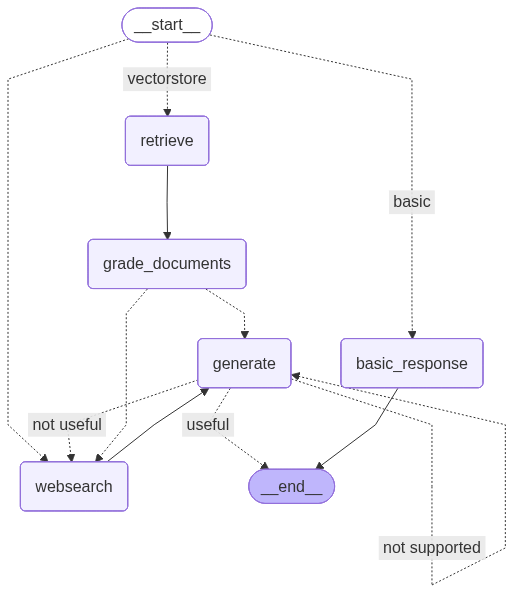

In [168]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass